# Imports & Display

In [52]:
#imports
import pandas as pd
import numpy as np
import requests
import re
import json
import unicodedata
import matplotlib.pyplot as plt
import statsmodels.api as sm

pd.set_option("display.max_columns", 100)

# Parameters for NYC APIs

In [53]:
DOMAIN = "data.cityofnewyork.us"

# NYC Open Data (DOE)
ELA_ID  = "iebs-5yhr"  # ELA Tests 2013–2023 (school geography)
MATH_ID = "74kb-55u9"  # Math Tests 2013–2023 (school geography)

# Census ACS (2022 5-year), ZCTA level (ZIP code tabulation areas)
ACS_ENDPOINT = "https://api.census.gov/data/2022/acs/acs5"

# Socrata Helper

In [54]:
def socrata_fetch_all(dataset_id, select=None, where=None, limit=50000):
    # pull rows from Socrata dataset as DataFrame
    base = f"https://{DOMAIN}/resource/{dataset_id}.json"
    frames, offset = [], 0
    while True:
        params = {"$limit": limit, "$offset": offset}
        if select: params["$select"] = select
        if where:  params["$where"]  = where
        r = requests.get(base, params=params, timeout=60)
        r.raise_for_status()
        rows = r.json()
        if not rows: break
        frames.append(pd.DataFrame(rows))
        offset += limit
        if len(rows) < limit: break
    return pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()


def pick(cols, options):
    # return first column present from a list of likely. names
    for o in options:
        if o in cols: return o
    return None


def to_percent_outcome(series):
    # convert outcomes to $ if needed and drop scale scores
    x = pd.to_numeric(series, errors="coerce")
    if x.dropna().empty: return x
    if (x.dropna() <= 1.2).mean() > 0.6:   # Proportions in 0-1
        return x * 100.0
    return x.mask(x.between(100, 1000, inclusive="both"))  # Drop scale-like values


def share_to_pct(series):
    # turn shares into percent and leave % as is
    x = pd.to_numeric(series, errors="coerce")
    if x.dropna().empty: return x
    return x * 100.0 if (x.dropna() <= 1.2).mean() > 0.6 else x


# Graduation Rates


In [73]:
# https://infohub.nyced.org/docs/default-source/default-document-library/2024-graduation-rates-public-school.xlsx
GRAD_CSV_PATH = "data_nyc_grad_all_students.csv"

def build_graduation_from_all_csv(path: str) -> pd.DataFrame:
    # read csv (fallback to latin1 if needed)
    try:
        df = pd.read_csv(path, dtype=str)
    except UnicodeDecodeError:
        df = pd.read_csv(path, dtype=str, encoding="latin1")

    # trim headers
    df.columns = [str(c).strip() for c in df.columns]
    cols = df.columns.tolist()

    # helper: first column whose name matches regex
    def pick_re(pattern, flags=re.I):
        for c in cols:
            if re.search(pattern, c, flags):
                return c
        return None

    # key columns (prefer exact DOE labels, then fallbacks)
    dbn_col     = next((c for c in cols if c.lower() in {"dbn","ats code","ats_code","school dbn","school_dbn"}), None)
    school_col  = next((c for c in cols if c.lower() in {"school name","school_name","name"}), None)
    cohort_yr_c = next((c for c in cols if c.lower() in {"cohort year","cohort_year"}), None)
    cohort_col  = next((c for c in cols if c.lower() == "cohort"), None)
    rate_col    = next((c for c in cols if c.lower() in {"% grads","% grad","% graduates","grad rate","% graduates"}), None)

    # regex fallbacks
    if dbn_col is None:
        for c in cols:
            if df[c].astype(str).str.match(r"^\d{2}[A-Z]\d{3}$", na=False).any():
                dbn_col = c; break
    if rate_col is None:
        rate_col = pick_re(r"(%)\s*.*grad")
    if cohort_yr_c is None:
        cohort_yr_c = pick_re(r"(cohort.*year|class.*year|report.*year)")
    if cohort_col is None:
        cohort_col = pick_re(r"^cohort$")

    # validate presence
    needed = {"DBN": dbn_col, "Cohort": cohort_col, "Cohort Year": cohort_yr_c, "% Grads": rate_col}
    if any(v is None for v in needed.values()):
        print("Columns found:", cols)
        raise ValueError("Missing one of: DBN, Cohort, Cohort Year, or % Grads")

    # keep All Students if file contains subgroups
    cat_col = next((c for c in cols if c.lower() == "category"), None)
    if cat_col and df[cat_col].notna().any():
        df = df[df[cat_col].astype(str).str.contains(r"^all\s*students$", case=False, na=False)]

    # restrict to 4-year August
    df = df[df[cohort_col].astype(str).str.contains(r"4\s*year\s*august", case=False, na=False)]

    # build tidy output
    out = pd.DataFrame()
    out["dbn"] = df[dbn_col].astype(str).str.strip().str.upper()
    out["school_name"] = df[school_col].astype(str).str.strip() if school_col else np.nan

    # clean percent → numeric
    rate_raw = df[rate_col].astype(str).str.replace("%","", regex=False).str.strip()
    bad = {"", "na", "n/a", "nan", "s", "-", "--", ".", "*"}
    rate_clean = rate_raw.str.lower().map(lambda x: np.nan if x in bad else x)
    out["grad_rate"] = pd.to_numeric(rate_clean, errors="coerce")

    # numeric year for latest selection
    out["_year"] = pd.to_numeric(
        df[cohort_yr_c].astype(str).str.extract(r"(\d{4})", expand=True)[0],
        errors="coerce"
    )

    # latest cohort per DBN and valid rates
    out = (
        out.sort_values("_year")
           .drop_duplicates(subset=["dbn"], keep="last")
           .dropna(subset=["dbn","grad_rate"])
           .copy()
    )

    # clamp to 0–100 and finalize
    out["grad_rate"] = out["grad_rate"].clip(0, 100)
    out = out[["dbn","school_name","grad_rate"]].reset_index(drop=True)
    return out

# run
grad = build_graduation_from_all_csv(GRAD_CSV_PATH)
display(grad.head(20))

,dbn,school_name,grad_rate
0,05M685,BREAD & ROSES INTEGRATED ARTS HS,39.4
1,05M469,CHOIR ACADEMY OF HARLEM,77.4
2,22K495,SHEEPSHEAD BAY HS,64.7
3,29Q496,BUSINESS COMPUTER APPLICATIONS & ENTREPRENEURS...,67.5
4,02M625,HS OF GRAPHIC COMMUNICATION ARTS,57.9
5,29Q494,LAW GOVERNMENT AND COMMUNITY SERVICE HS,78.7
6,09X414,JONATHAN LEVIN HS FOR MEDIA AND COMMUNICATIONS,39.5
7,12X278,PEACE AND DIVERSITY ACADEMY,0.0
8,13K499,ACORN COMMUNITY HIGH SCHOOL,57.6
9,01M509,MARTA VALLE HIGH SCHOOL,50.0


# Grades 3-8 ELA & Math

In [74]:
def _norm_name_series(s: pd.Series) -> pd.Series:
    # normalize for name matching
    s = s.astype(str).str.upper()
    s = s.apply(lambda x: unicodedata.normalize("NFKD", x))
    s = s.apply(lambda x: "".join(ch for ch in x if not unicodedata.combining(ch)))
    s = s.str.replace(r"[^A-Z0-9 ]+", " ", regex=True)
    s = s.str.replace(r"\s+", " ", regex=True).str.strip()
    return s.mask(s.eq(""), np.nan)

def _safe_to_percent(series, index=None) -> pd.Series:
    # handle "%" strings and 0–1 proportions
    if series is None:
        return pd.Series(np.nan, index=index) if index is not None else pd.Series(dtype=float)
    if not isinstance(series, pd.Series):
        series = pd.Series(series, index=index)
    s = series.astype(str).str.replace("%","", regex=False)
    x = pd.to_numeric(s, errors="coerce")
    if x.dropna().empty:
        return pd.Series(np.nan, index=series.index)
    if (x.dropna() <= 1.2).mean() > 0.6:
        x = x * 100.0
    return x.mask(x.between(100, 1000, inclusive="both"))

def _extract_year(df: pd.DataFrame) -> pd.Series:
    # best-effort 4-digit year from common fields
    for c in ["year","school_year","report_school_year","test_year","data_year","admin_year","administration_year","cohort_year"]:
        if c in df.columns:
            y = pd.to_numeric(df[c].astype(str).str.extract(r"(\d{4})", expand=True)[0], errors="coerce")
            if y.notna().any(): return y
    for c in df.columns:
        if df[c].dtype == "object":
            y = pd.to_numeric(df[c].astype(str).str.extract(r"(\d{4})", expand=True)[0], errors="coerce")
            if y.notna().any(): return y
    return pd.Series(np.nan, index=df.index)

def _best_percent_from_counts(df: pd.DataFrame, prefer_math=True) -> pd.Series:
    # percent from counts; prefer math-like names when ties
    def is_ela_name(c): return bool(re.search(r"\b(ela|english)\b", c, re.I))
    def is_math_name(c): return bool(re.search(r"\b(math|algebra|geom|arith)\b", c, re.I))

    nums = [c for c in df.columns if re.search(r"(levels?_?3_?4|proficient|passing|num_?prof)", c, re.I)]
    dens = [c for c in df.columns if re.search(r"(tested|total_?tested|number_?tested|n_?tested|total_students|total)", c, re.I)]

    best_s, best_score = pd.Series(np.nan, index=df.index), -1
    for n in nums:
        for d in dens:
            num = pd.to_numeric(df[n], errors="coerce")
            den = pd.to_numeric(df[d], errors="coerce")
            s = pd.Series(np.where((den > 0) & num.notna(), (num/den)*100.0, np.nan), index=df.index)
            sane = s.dropna()
            if sane.empty:
                continue
            cov = s.notna().mean()
            pct_sane = sane.between(0,100).mean()
            score = cov + 0.5*pct_sane
            if prefer_math:
                if is_math_name(n) or is_math_name(d): score += 0.2
                if is_ela_name(n)  or is_ela_name(d):  score -= 0.2
            if score > best_score:
                best_s, best_score = s, score
    return best_s

# cache name→DBN map from snapshot
_name_dbn_cache = None
def _name_to_dbn_map():
    global _name_dbn_cache
    if _name_dbn_cache is not None:
        return _name_dbn_cache
    snap = socrata_fetch_all(SNAP_ID)
    dbn_col  = pick(snap.columns, ["dbn","school_dbn","dbn_code","ats_system_code","school_code"])
    name_col = pick(snap.columns, ["school_name","school","name","location_name"])
    m = snap[[dbn_col, name_col]].copy()
    m.columns = ["dbn_raw","school_name"]
    m["dbn"] = m["dbn_raw"].astype(str).str.upper()
    m["school_name_norm"] = _norm_name_series(m["school_name"])
    _name_dbn_cache = m.loc[m["school_name_norm"].notna(), ["school_name_norm","dbn"]].drop_duplicates()
    return _name_dbn_cache

def fetch_ela_percent(ela_id: str) -> pd.DataFrame:
    # ELA percent by DBN
    df = socrata_fetch_all(ela_id)
    if df.empty: return pd.DataFrame(columns=["dbn","ela_percent"])

    dbn_col  = pick(df.columns, ["dbn","school_dbn","ats_system_code","school_code","dbn_code"])
    name_col = pick(df.columns, ["school_name","school","name","location_name"])
    if dbn_col:
        df["dbn"] = df[dbn_col].astype(str).str.upper()
    elif name_col:
        df["school_name_norm"] = _norm_name_series(df[name_col])
        df = df.merge(_name_to_dbn_map(), on="school_name_norm", how="left")
        df = df[df["dbn"].notna()]
        if df.empty: return pd.DataFrame(columns=["dbn","ela_percent"])
    else:
        return pd.DataFrame(columns=["dbn","ela_percent"])

    # all-students, ELA subject, all-grades filters where available
    for c in ["subject","test","assessment","content_area","exam","entity","category","report_category"]:
        if c in df.columns:
            m = df[c].astype(str).str.contains(r"\bELA\b|English Language Arts", case=False, na=False)
            if m.any(): df = df[m]; break
    for c in ["subgroup","student_group","student_category","demographic","population","group","category","report_category"]:
        if c in df.columns:
            m = df[c].astype(str).str.contains(r"^all\b.*students\b|^all\s*students$", case=False, na=False)
            if m.any(): df = df[m]; break
    for c in ["grade","grade_level","grade_band","grade_category","grade_group"]:
        if c in df.columns:
            m = df[c].astype(str).str.contains(r"^all\b.*grades\b|^all\s*grades$|^all$", case=False, na=False)
            if m.any(): df = df[m]; break

    pct_col = next((c for c in df.columns if re.search(r"(percent|pct).*?(proficient|levels?_?3_?4)", c, re.I)), None)
    if pct_col:
        pct = _safe_to_percent(df[pct_col], index=df.index)
    else:
        pct = _best_percent_from_counts(df, prefer_math=False)

    df["ela_percent"] = _safe_to_percent(pct, index=df.index)
    df = df.dropna(subset=["ela_percent"])

    y = _extract_year(df)
    if y.notna().any():
        df = df.assign(__year=y).sort_values("__year").drop_duplicates(subset=["dbn"], keep="last")

    return df[["dbn","ela_percent"]].drop_duplicates(subset=["dbn"])

def fetch_math_percent(math_id: str, ela_id: str) -> pd.DataFrame:
    # Math percent by DBN, robust to mixed tables
    def _try(ds):
        try: return socrata_fetch_all(ds)
        except requests.HTTPError: return pd.DataFrame()

    df = _try(math_id); used_id = math_id
    if df.empty:
        df = _try(ela_id); used_id = ela_id
        if df.empty:
            print("[MATH] Both provided datasets empty.")
            return pd.DataFrame(columns=["dbn","math_percent"])

    dbn_col  = pick(df.columns, ["dbn","school_dbn","ats_system_code","school_code","dbn_code"])
    name_col = pick(df.columns, ["school_name","school","name","location_name"])
    if dbn_col:
        df["dbn"] = df[dbn_col].astype(str).str.upper()
    elif name_col:
        df["school_name_norm"] = _norm_name_series(df[name_col])
        df = df.merge(_name_to_dbn_map(), on="school_name_norm", how="left")
        df = df[df["dbn"].notna()]
        if df.empty:
            print("[MATH] Name→DBN map produced no matches.")
            return pd.DataFrame(columns=["dbn","math_percent"])
    else:
        print("[MATH] No DBN or school name column found.")
        return pd.DataFrame(columns=["dbn","math_percent"])

    subj_col = pick(df.columns, ["subject","test","assessment","content_area","exam","entity","category","report_category"])
    if subj_col:
        subj_vals = df[subj_col].astype(str)
        m_mask = subj_vals.str.contains(r"\bmath|mathemat", case=False, na=False)
        e_mask = subj_vals.str.contains(r"\bela|english", case=False, na=False)
        df_math = df[m_mask].copy() if m_mask.any() else df[~e_mask].copy()
    else:
        df_math = df.copy()

    pct_cols = [c for c in df_math.columns if re.search(r"(percent|pct)", c, re.I) and "math" in c.lower()]
    pct = None
    if pct_cols:
        coverage = {c: pd.to_numeric(df_math[c].astype(str).str.replace("%","", regex=False), errors="coerce").notna().mean()
                    for c in pct_cols}
        best = max(coverage, key=coverage.get)
        pct = df_math[best]

    if pct is None or pd.to_numeric(_safe_to_percent(pct), errors="coerce").notna().sum() < 10:
        pct = _best_percent_from_counts(df_math, prefer_math=True)

    if pd.to_numeric(_safe_to_percent(pct), errors="coerce").notna().sum() < 10:
        gen_pct_cols = [c for c in df_math.columns if re.search(r"(percent|pct)", c, re.I) and "ela" not in c.lower()]
        best_vals, cov_best = None, -1
        for c in gen_pct_cols:
            vals = _safe_to_percent(df_math[c], index=df_math.index)
            cov = pd.to_numeric(vals, errors="coerce").notna().mean()
            if cov > cov_best:
                cov_best, best_vals = cov, vals
        if best_vals is not None:
            pct = best_vals

    tmp = _safe_to_percent(pct, index=df_math.index)
    if tmp.notna().sum() == 0:
        print("[MATH] No usable percent found.")
        print(f"[MATH] Dataset tried: {used_id}")
        print("[MATH] Columns:", list(df_math.columns))
        if subj_col:
            print("[MATH] Subject sample:", df_math[subj_col].astype(str).dropna().head(20).tolist())
        return pd.DataFrame(columns=["dbn","math_percent"])

    df_math["math_percent"] = tmp
    df_math = df_math.dropna(subset=["math_percent"])

    y = _extract_year(df_math)
    if y.notna().any():
        df_math = df_math.assign(__year=y).sort_values("__year").drop_duplicates(subset=["dbn"], keep="last")

    return df_math[["dbn","math_percent"]].drop_duplicates(subset=["dbn"])

# run
ela  = fetch_ela_percent(ELA_ID)
math = fetch_math_percent(MATH_ID, ELA_ID)
display(ela.head(10))
display(math.head(10))


,dbn,ela_percent
40794,02M407,40.740741
58459,16K025,53.333333
57064,14K586,30.597015
38903,01M364,21.875000
38251,01M015,31.081081
41741,03M242,13.513514
42841,04M108,32.820513
66447,22K381,53.267974
46824,08X036,40.506329
57457,15K058,75.337838


,dbn,math_percent
621054,84K037,27.5
621064,84K125,24.1
621090,84K129,10.8
621099,84K182,4.2
621132,84K333,38.0
621169,84K355,29.1
621211,84K356,42.7
621258,84K357,30.2
621307,84K358,31.6
621320,84K360,24.2


# Demographic Snapshot

In [75]:
# https://data.cityofnewyork.us/Education/2017-18-2021-22-Demographic-Snapshot/c7ru-d68s/about_data
DEMO_CSV_PATH = "data_demographic_snapshot_school.csv"

def _latest_year_per_dbn(df, year_col="year"):
    # keep latest year per DBN
    y = pd.to_numeric(df[year_col], errors="coerce")
    temp = df.assign(_year=y).sort_values("_year")
    return temp.drop_duplicates(subset=["dbn"], keep="last").drop(columns=["_year"])

def _percent_from_pair(df, count_col, pct_col, denom_col):
    # prefer stored percent; else compute from counts; return 0–100
    out = pd.Series(np.nan, index=df.index, dtype=float)
    if pct_col in df.columns:
        s = df[pct_col].astype(str).str.strip().str.replace("%", "", regex=False)
        s = s.replace({"": np.nan, ".": np.nan, "-": np.nan, "s": np.nan, "S": np.nan})
        s = pd.to_numeric(s, errors="coerce")
        if s.notna().any():
            out = s*100.0 if (s.dropna() <= 1.2).mean() > 0.6 else s
    if out.isna().all() and count_col in df.columns and denom_col in df.columns:
        num = pd.to_numeric(df[count_col], errors="coerce")
        den = pd.to_numeric(df[denom_col], errors="coerce")
        out = np.where(den > 0, (num/den)*100.0, np.nan)
    return pd.to_numeric(out, errors="coerce").clip(0, 100)

def _borough_from_dbn(dbn: pd.Series) -> pd.Series:
    # DBN → borough
    letter = dbn.astype(str).str.strip().str[2:3].str.upper()
    mapping = {"M": "Manhattan", "K": "Brooklyn", "Q": "Queens", "X": "Bronx", "R": "Staten Island"}
    return letter.map(mapping)

def _district_from_dbn(dbn: pd.Series) -> pd.Series:
    # DBN → district
    return pd.to_numeric(dbn.astype(str).str.strip().str[:2], errors="coerce")

def _parse_eni(series: pd.Series) -> pd.Series:
    # economic need index as 0–1
    s = series.astype(str).str.strip().str.lower().str.replace("%","", regex=False)
    s = s.str.replace(r"[^0-9\.\-]", "", regex=True)
    s = pd.to_numeric(s, errors="coerce")
    if s.dropna().gt(1.2).mean() > 0.6:
        s = s/100.0
    return s.clip(0, 1)

def build_demo_snapshot_no_teachers_zip(path: str) -> pd.DataFrame:
    # read csv with lenient encoding
    try:
        df = pd.read_csv(path, dtype=str)
    except UnicodeDecodeError:
        df = pd.read_csv(path, dtype=str, encoding="latin1")

    # basic column checks
    df.columns = [c.strip() for c in df.columns]
    for r in ["dbn","school_name","year","total_enrollment"]:
        if r not in df.columns:
            raise ValueError(f"Missing required column '{r}'. Found: {df.columns.tolist()}")

    # normalize key fields
    df["dbn"] = df["dbn"].astype(str).str.upper().str.strip()
    df["school_name"] = df["school_name"].astype(str).str.strip()
    df["total_enrollment"] = pd.to_numeric(df["total_enrollment"], errors="coerce")

    # latest year per DBN
    df_latest = _latest_year_per_dbn(df, year_col="year")

    # output table
    demo = pd.DataFrame()
    demo["dbn"] = df_latest["dbn"]
    demo["school_name"] = df_latest["school_name"]
    demo["borough"] = _borough_from_dbn(demo["dbn"])
    demo["district"] = _district_from_dbn(demo["dbn"])
    demo["enrollment"] = df_latest["total_enrollment"].astype(float)

    # race/ethnicity shares
    demo["school_asian_share"]    = _percent_from_pair(df_latest, "asian",    "asian_1",    "total_enrollment")
    demo["school_black_share"]    = _percent_from_pair(df_latest, "black",    "black_1",    "total_enrollment")
    demo["school_hispanic_share"] = _percent_from_pair(df_latest, "hispanic", "hispanic_1", "total_enrollment")
    demo["school_white_share"]    = _percent_from_pair(df_latest, "white",    "white_1",    "total_enrollment")

    # economic need index
    demo["economic_need_index"] = _parse_eni(df_latest.get("economic_need_index", pd.Series(index=df_latest.index)))

    # finalize
    demo = (demo
            .dropna(subset=["dbn"])
            .drop_duplicates(subset=["dbn"])
            .reset_index(drop=True))
    return demo

# run
demo = build_demo_snapshot_no_teachers_zip(DEMO_CSV_PATH)
display(demo.head(10))


,dbn,school_name,borough,district,enrollment,school_asian_share,school_black_share,school_hispanic_share,school_white_share,economic_need_index
0,01M015,P.S. 015 Roberto Clemente,Manhattan,1,179.0,11.7,27.9,52.0,6.7,0.879
1,01M019,P.S. 019 Asher Levy,Manhattan,1,176.0,5.7,18.2,57.4,11.9,0.678
2,01M020,P.S. 020 Anna Silver,Manhattan,1,351.0,19.7,15.1,54.7,7.7,0.753
3,01M034,P.S. 034 Franklin D. Roosevelt,Manhattan,1,258.0,3.1,41.5,52.7,2.3,0.944
4,01M063,The STAR Academy - P.S.63,Manhattan,1,186.0,1.6,20.4,64.5,7.5,0.704
5,01M064,P.S. 064 Robert Simon,Manhattan,1,215.0,2.8,19.5,74.0,1.9,0.863
6,01M110,P.S. 110 Florence Nightingale,Manhattan,1,330.0,12.1,10.6,47.3,27.0,0.663
7,01M134,P.S. 134 Henrietta Szold,Manhattan,1,177.0,7.3,28.8,58.2,1.7,0.950
8,01M140,P.S. 140 Nathan Straus,Manhattan,1,340.0,2.4,19.7,72.4,4.1,0.917
9,01M142,P.S. 142 Amalia Castro,Manhattan,1,330.0,0.3,16.4,76.1,4.5,0.897


# Consolidated Table

In [64]:
# keep only needed columns from each input
ela_min  = ela[["dbn","ela_percent"]].copy()            if "ela_percent"  in ela.columns  else pd.DataFrame(columns=["dbn","ela_percent"])
math_min = math[["dbn","math_percent"]].copy()          if "math_percent" in math.columns else pd.DataFrame(columns=["dbn","math_percent"])
grad_min = grad[["dbn","grad_rate"]].copy()             if "grad_rate"    in grad.columns else pd.DataFrame(columns=["dbn","grad_rate"])

# start from demographics so every row has features
df = demo.copy()

# merge outcomes
for part in (ela_min, math_min, grad_min):
    if "dbn" in part.columns:
        df = df.merge(part, on="dbn", how="left")

# numeric sanitation
for c in ["ela_percent","math_percent","grad_rate","enrollment",
          "school_asian_share","school_black_share","school_hispanic_share","school_white_share",
          "economic_need_index"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# engineered features used later
if "enrollment" in df.columns:
    df["log_enrollment"] = np.log1p(df["enrollment"])           # log-scaled size
if {"ela_percent","math_percent"}.issubset(df.columns):
    df["perf_index"] = df[["ela_percent","math_percent"]].mean(axis=1)  # simple composite

df.head(10)

,dbn,school_name,borough,district,enrollment,school_asian_share,school_black_share,school_hispanic_share,school_white_share,economic_need_index,ela_percent,math_percent,grad_rate,log_enrollment,perf_index
0,01M015,P.S. 015 Roberto Clemente,Manhattan,1,179.0,11.7,27.9,52.0,6.7,0.879,31.081081,25.9,NaN,5.192957,28.490541
1,01M019,P.S. 019 Asher Levy,Manhattan,1,176.0,5.7,18.2,57.4,11.9,0.678,NaN,NaN,NaN,5.176150,NaN
2,01M020,P.S. 020 Anna Silver,Manhattan,1,351.0,19.7,15.1,54.7,7.7,0.753,29.032258,33.3,NaN,5.863631,31.166129
3,01M034,P.S. 034 Franklin D. Roosevelt,Manhattan,1,258.0,3.1,41.5,52.7,2.3,0.944,31.250000,3.6,NaN,5.556828,17.425000
4,01M063,The STAR Academy - P.S.63,Manhattan,1,186.0,1.6,20.4,64.5,7.5,0.704,45.000000,35.6,NaN,5.231109,40.300000
5,01M064,P.S. 064 Robert Simon,Manhattan,1,215.0,2.8,19.5,74.0,1.9,0.863,40.259740,28.9,NaN,5.375278,34.579870
6,01M110,P.S. 110 Florence Nightingale,Manhattan,1,330.0,12.1,10.6,47.3,27.0,0.663,62.400000,31.5,NaN,5.802118,46.950000
7,01M134,P.S. 134 Henrietta Szold,Manhattan,1,177.0,7.3,28.8,58.2,1.7,0.950,16.250000,14.0,NaN,5.181784,15.125000
8,01M140,P.S. 140 Nathan Straus,Manhattan,1,340.0,2.4,19.7,72.4,4.1,0.917,33.908046,23.3,NaN,5.831882,28.604023
9,01M142,P.S. 142 Amalia Castro,Manhattan,1,330.0,0.3,16.4,76.1,4.5,0.897,36.666667,20.8,NaN,5.802118,28.733333


# Quick Data QA (Non-Nulls, Mean, STD)

In [76]:
#quick QA on key columns
cols_check = [c for c in [
    "ela_percent","math_percent","grad_rate","perf_index",
    "economic_need_index","enrollment","log_enrollment",
    "school_asian_share","school_black_share","school_hispanic_share","school_white_share"
] if c in df.columns]

qa = pd.DataFrame({
    "non_null": [df[c].notna().sum() for c in cols_check],
    "mean":     [df[c].mean() for c in cols_check],
    "std":      [df[c].std()  for c in cols_check]
}, index=cols_check)

qa.round(2)

,non_null,mean,std
ela_percent,1117,49.09,19.06
math_percent,1292,31.45,11.68
grad_rate,466,83.47,18.18
perf_index,1292,38.76,13.74
economic_need_index,1882,0.75,0.19
enrollment,1882,533.63,446.35
log_enrollment,1882,6.06,0.65
school_asian_share,1882,11.66,16.46
school_black_share,1882,29.85,25.36
school_hispanic_share,1882,43.94,24.64


# EDA Plots (Distributions + Relationships)

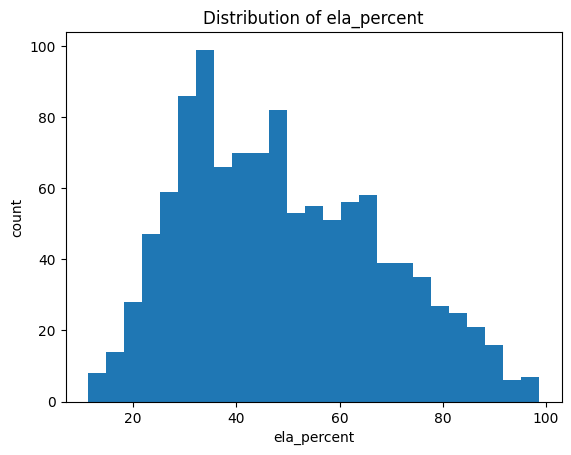

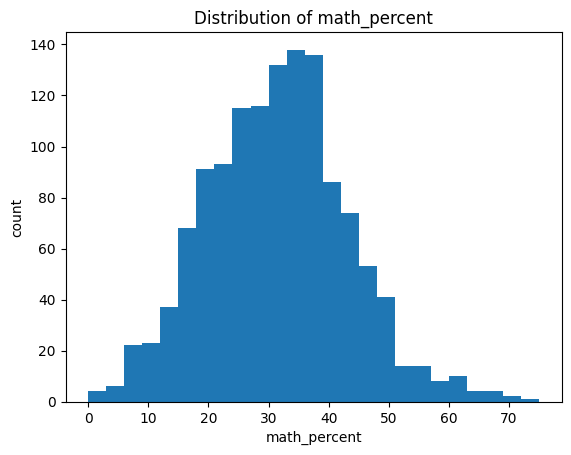

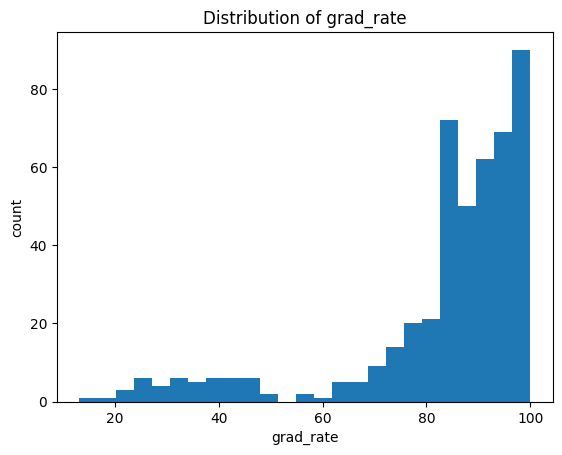

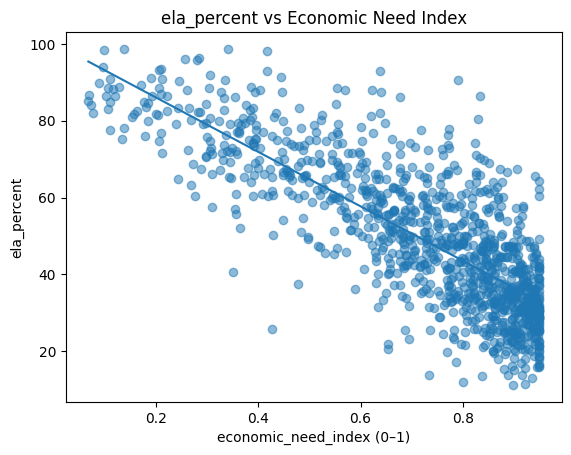

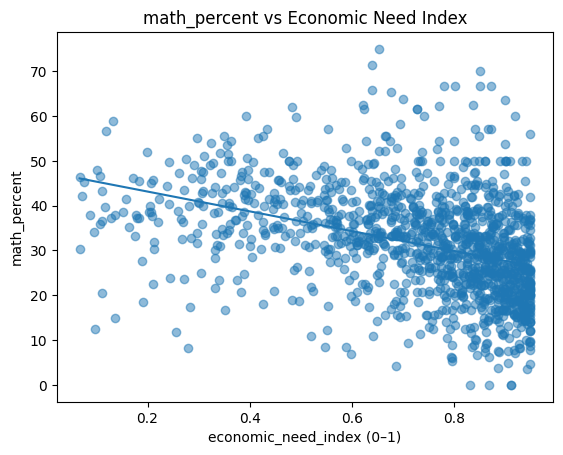

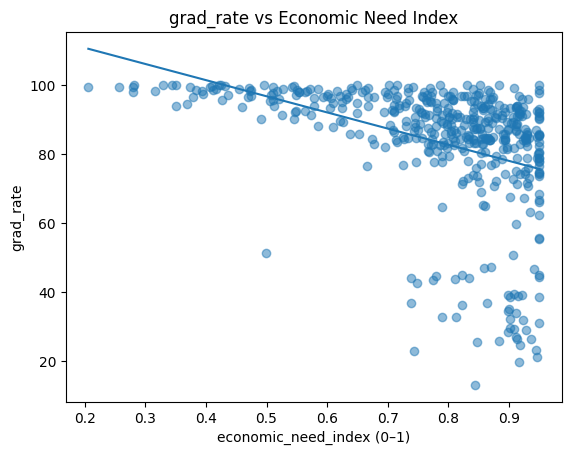

In [61]:
# histograms for outcomes
for col in [c for c in ["ela_percent","math_percent","grad_rate"] if c in df.columns]:
    plt.figure()
    df[col].dropna().plot(kind="hist", bins=25)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("count")
    plt.show()

# scatter with simple trend (polyfit) vs economic need
if "economic_need_index" in df.columns:
    for col in [c for c in ["ela_percent","math_percent","grad_rate"] if c in df.columns]:
        tmp = df[[col,"economic_need_index"]].dropna()
        if len(tmp) > 5:
            x = tmp["economic_need_index"].values
            y = tmp[col].values
            # linear fit for visual trend
            coef = np.polyfit(x, y, 1)
            line = np.poly1d(coef)

            plt.figure()
            plt.scatter(x, y, alpha=0.5)
            xv = np.linspace(x.min(), x.max(), 100)
            plt.plot(xv, line(xv))
            plt.title(f"{col} vs Economic Need Index")
            plt.xlabel("economic_need_index (0–1)")
            plt.ylabel(col)
            plt.show()

# OLS Models (ELA, Math, Graduation)


In [67]:
import statsmodels.formula.api as smf

# choose predictors that exist
base_feats = ['eni_percent','log_enrollment',
              'school_asian_share','school_black_share','school_hispanic_share']  # leave white out to avoid perfect collinearity
preds = [c for c in base_feats if c in df.columns]
fe_borough = ' + C(borough)' if 'borough' in df.columns else ''

def run_ols(ycol):
    cols_needed = preds + [ycol]
    cols_needed += ['borough'] if 'borough' in df.columns else []
    d = df[cols_needed].dropna()
    if d.empty:
        print(f"Skip OLS: no rows for {ycol}")
        return None
    formula = f"{ycol} ~ {' + '.join(preds)}{fe_borough}"
    print("Model:", formula)
    model = smf.ols(formula, data=d).fit(cov_type='HC1')
    display(model.summary2().tables[1])  # coefficients table
    print("N:", len(d))
    return model

model_ela  = run_ols('ela_percent')  if 'ela_percent'  in df_model.columns else None
model_math = run_ols('math_percent') if 'math_percent' in df_model.columns else None
model_grad = run_ols('grad_rate')    if 'grad_rate'    in df_model.columns else None

Model: grad_rate ~ log_enrollment + school_asian_share + school_black_share + school_hispanic_share + C(borough)


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,27.792298,12.377480,2.245392,2.474296e-02,3.532883,52.051714
C(borough)[T.Brooklyn],-4.024040,2.350809,-1.711768,8.693939e-02,-8.631541,0.583461
C(borough)[T.Manhattan],-0.211519,2.311035,-0.091526,9.270749e-01,-4.741065,4.318027
C(borough)[T.Queens],-3.720063,2.622873,-1.418316,1.560984e-01,-8.860799,1.420673
C(borough)[T.Staten Island],-13.450883,5.108861,-2.632854,8.467085e-03,-23.464066,-3.437699
log_enrollment,11.319436,1.574962,7.187116,6.617398e-13,8.232567,14.406305
school_asian_share,-0.102640,0.091373,-1.123303,2.613089e-01,-0.281729,0.076449
school_black_share,-0.102374,0.062441,-1.639528,1.011033e-01,-0.224757,0.020008
school_hispanic_share,-0.149292,0.054786,-2.724982,6.430502e-03,-0.256671,-0.041913


N: 466


# Standardized Effect Sizes

In [68]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# z-score
def zscore(series):
    s = pd.to_numeric(series, errors='coerce')
    mu = s.mean()
    sd = s.std(ddof=0)
    return (s - mu) / sd if sd and not np.isnan(sd) else s*0

# betas
def std_betas(ycol):
    cols = preds + [ycol]
    cols += ['borough'] if 'borough' in df.columns else []
    d = df[cols].dropna()
    if d.empty:
        print(f"Skip std betas: no data for {ycol}")
        return None
    z = d.copy()
    for c in preds + [ycol]:
        z[c] = zscore(z[c])
    formula = f"{ycol} ~ {' + '.join(preds)}{fe_borough}"
    m = smf.ols(formula, data=z).fit(cov_type='HC1')
    coefs = m.params.filter(items=preds).sort_values(key=lambda s: s.abs(), ascending=False)
    display(coefs.to_frame(name=f'std_beta_{ycol}'))
    return coefs

std_ela  = std_betas('ela_percent')  if 'ela_percent'  in df.columns else None
std_math = std_betas('math_percent') if 'math_percent' in df.columns else None
std_grad = std_betas('grad_rate')    if 'grad_rate'    in df.columns else None

,std_beta_ela_percent
school_hispanic_share,-0.834269
school_black_share,-0.677858
school_asian_share,-0.210588
log_enrollment,0.070775


,std_beta_math_percent
school_black_share,-0.422974
school_hispanic_share,-0.404899
school_asian_share,-0.183373
log_enrollment,0.020175


,std_beta_grad_rate
log_enrollment,0.465184
school_hispanic_share,-0.190880
school_black_share,-0.127240
school_asian_share,-0.076593
